In [1]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import pandas as pd
%matplotlib inline

from explore.ContCont import ContCont
from explore.ContCat import ContCat
from explore.CatCat import CatCat

from explore.SingleBlock import SingleBlock
from explore.BlockBlock import BlockBlock

/anaconda3/envs/swdb/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# load datasets

- **df** is the dataframe whose columns are both X and y 
    - X follows a gaussian mixture whose component labels are y
    - y has three classes


- **pca** is the dataframe with pca_scores and y_hat on the columns

    - pca_scores is the first few principal components of X 

    - y_hat is the estimated clusters from a gaussian mixture model fit on pca_scores
    
    - y_hat has three classes


In [2]:
X, y = make_classification(n_samples=200,
                           n_features=5,
                           n_informative=3,
                           n_redundant=0,
                           n_classes=3,
                           n_clusters_per_class=1,
                           random_state=0)

# Put data into Pandas framework
y = pd.Series(y, name='classes', dtype='category')

var_names = ['feat_{}'.format(i + 1) for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=var_names)
df['classes'] = y

print('shape of df:', df.shape)


# fit PCA
pca_scores  = PCA(n_components=3).fit_transform(X)
pca  = pd.DataFrame(pca_scores,
                    columns=['pca_comp_{}'.format(i + 1) for i in range(pca_scores.shape[1])])

# cluster PCA scores
gmm = GaussianMixture(n_components=3)
y_hat = gmm.fit_predict(pca)
y_hat = pd.Series(y_hat, name='clusters', dtype='category')
pca['clusters'] = y_hat

print('shape of pca:', pca.shape)

shape of df: (200, 6)
shape of pca: (200, 4)


# Continuous vs. continuous

- scatter plot of two continuous variables
- measure pearson correlation
- test of correlation is significant

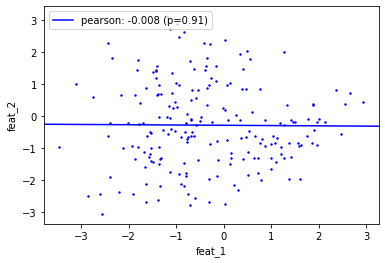

In [3]:
ctscat = ContCont(alpha=0.05, measure='pearson') # can choose spearman or pearson correlation
ctscat.fit(df['feat_1'], df['feat_2'])
ctscat.plot()

# Continuous vs. categorical

Compare a continuous variable, df['feat_1'], to a categorical variable, df['classes'] which has 3 classes

- do all one-vs-one difference in distribution tests for classes of y
- compute AUC score and do Mann Whitney U test to assest if difference is significant
    - note the Mann Whitney U statistics is equivalent -- upto rescaling -- to the AUC score
- plot class conditional kernel desnisty estimates
    - the area under each density is proportional to the number of samples
    - show individual data points though jitter plot where the y value is determined by the order they show up in the dataframe
- plot overall (i.e. undconditional) KDE in grey

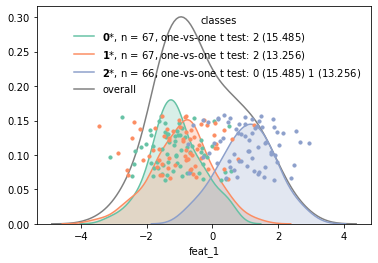

In [4]:
cc = ContCat(test='t', multi_cat='ovo') # use a t-test and do all one-vs-one comparisons
cc.fit(df['feat_1'], df['classes'])
cc.plot()

We can also do all one-vs-rest comparisons

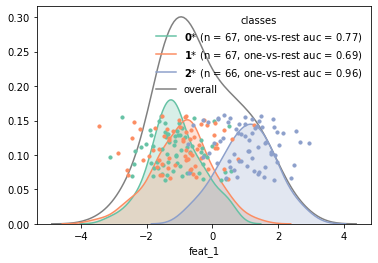

In [5]:
# do a Mann-Whitney test (reporting the AUC score) and do all one-vs-rest comparisons
cc = ContCat(test='auc', multi_cat='ovr') 
cc.fit(df['feat_1'], df['classes'])
cc.plot()

# Categorical vs. categorical


Compare two categorical variables (both with three classes) with a contingency table

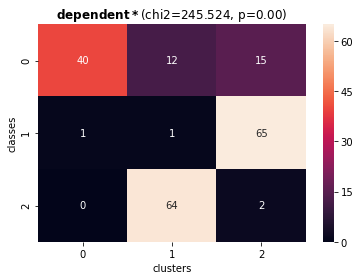

In [6]:
catcat = CatCat() # do chi square test of independence
catcat.fit(df['classes'], y_hat)
catcat.plot()

# Compare all pairs of variables in a data matrix

Compare all pairs of variables in the data frame and correct for multiple testing.

- df is a dataframe with 6 variables
    - the original 5 variables
    - the true class labels

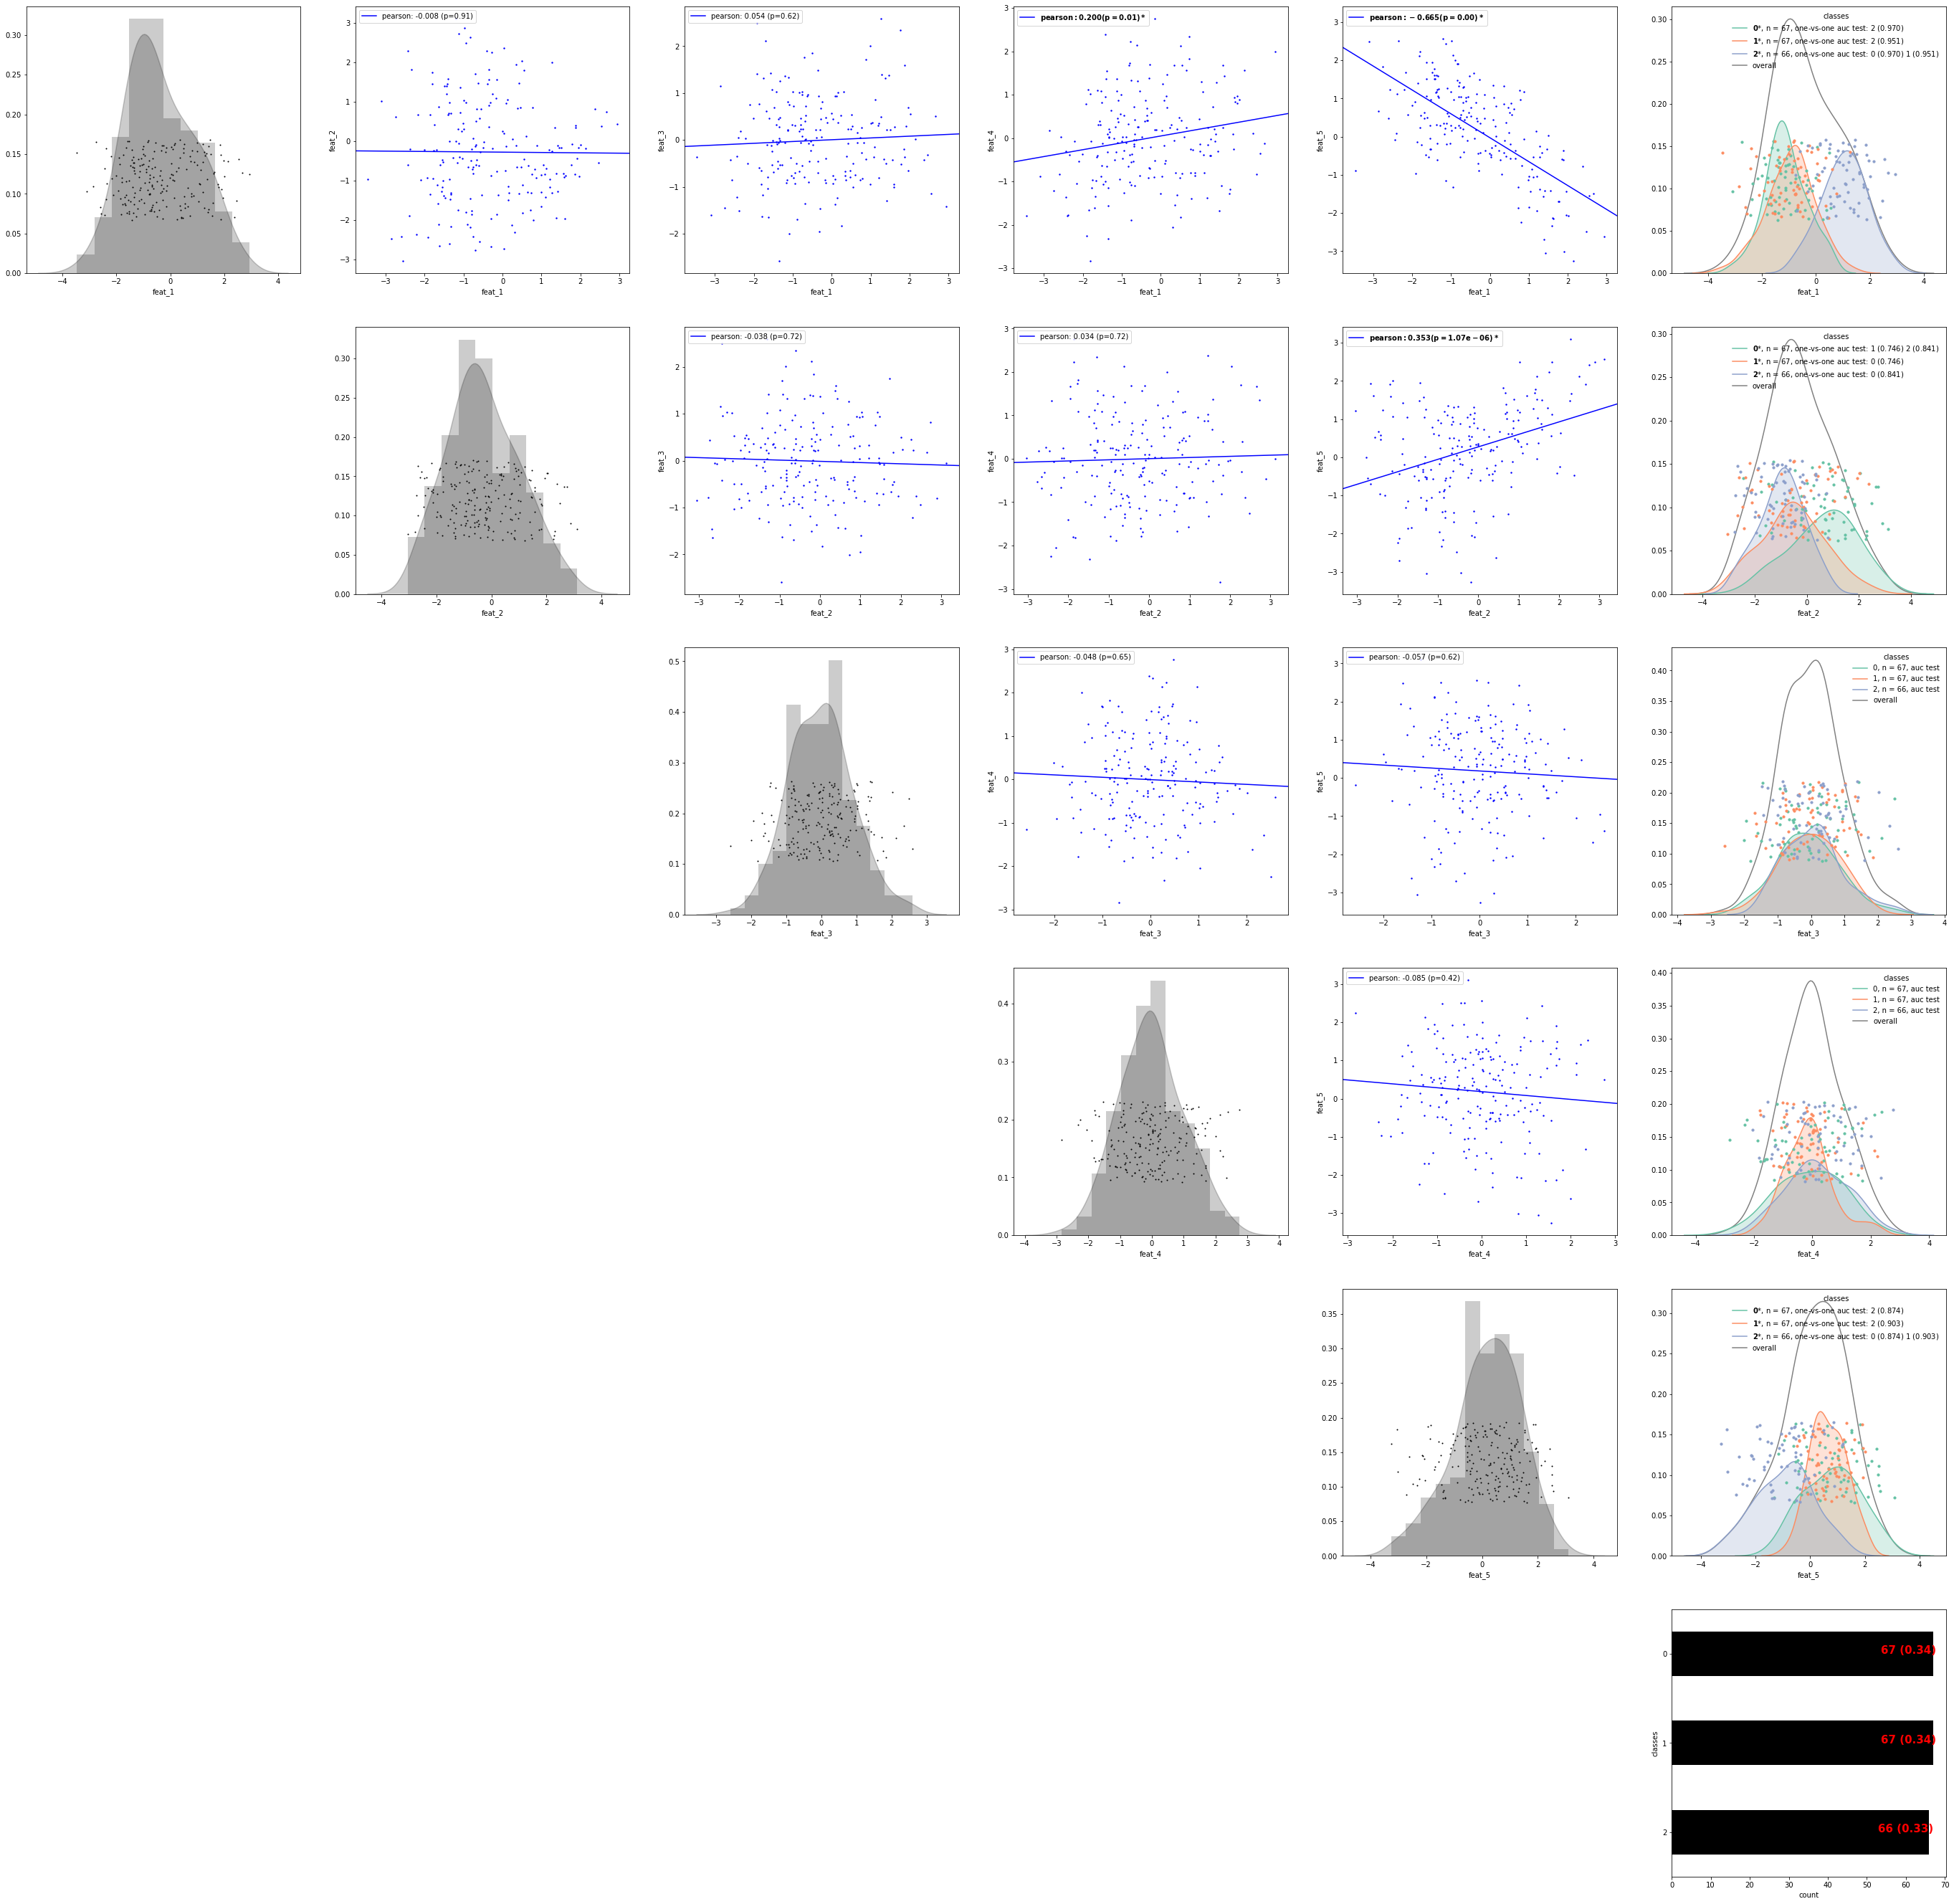

In [7]:
sb = SingleBlock(multi_test='fdr_bh', # benjamini hochberg for multiple testing correction
                 corr='pearson', # use pearson correlation for continuos-continuous comparisons
                 cat_test='auc', multi_cat='ovo') # use one-vs-one auc tests for continuos-cat comparisons 
sb.fit(df)
sb.correct_multi_tests()
sb.plot()

# Compare all pairs of variables between two data matrices

Compare all pairs of variables between data frames and correct for multiple testing.



- pca is a data frame with 4 variables
    - first 3 principal components
    - the estimated cluster labels from applying a GMM to the PCA scores
    

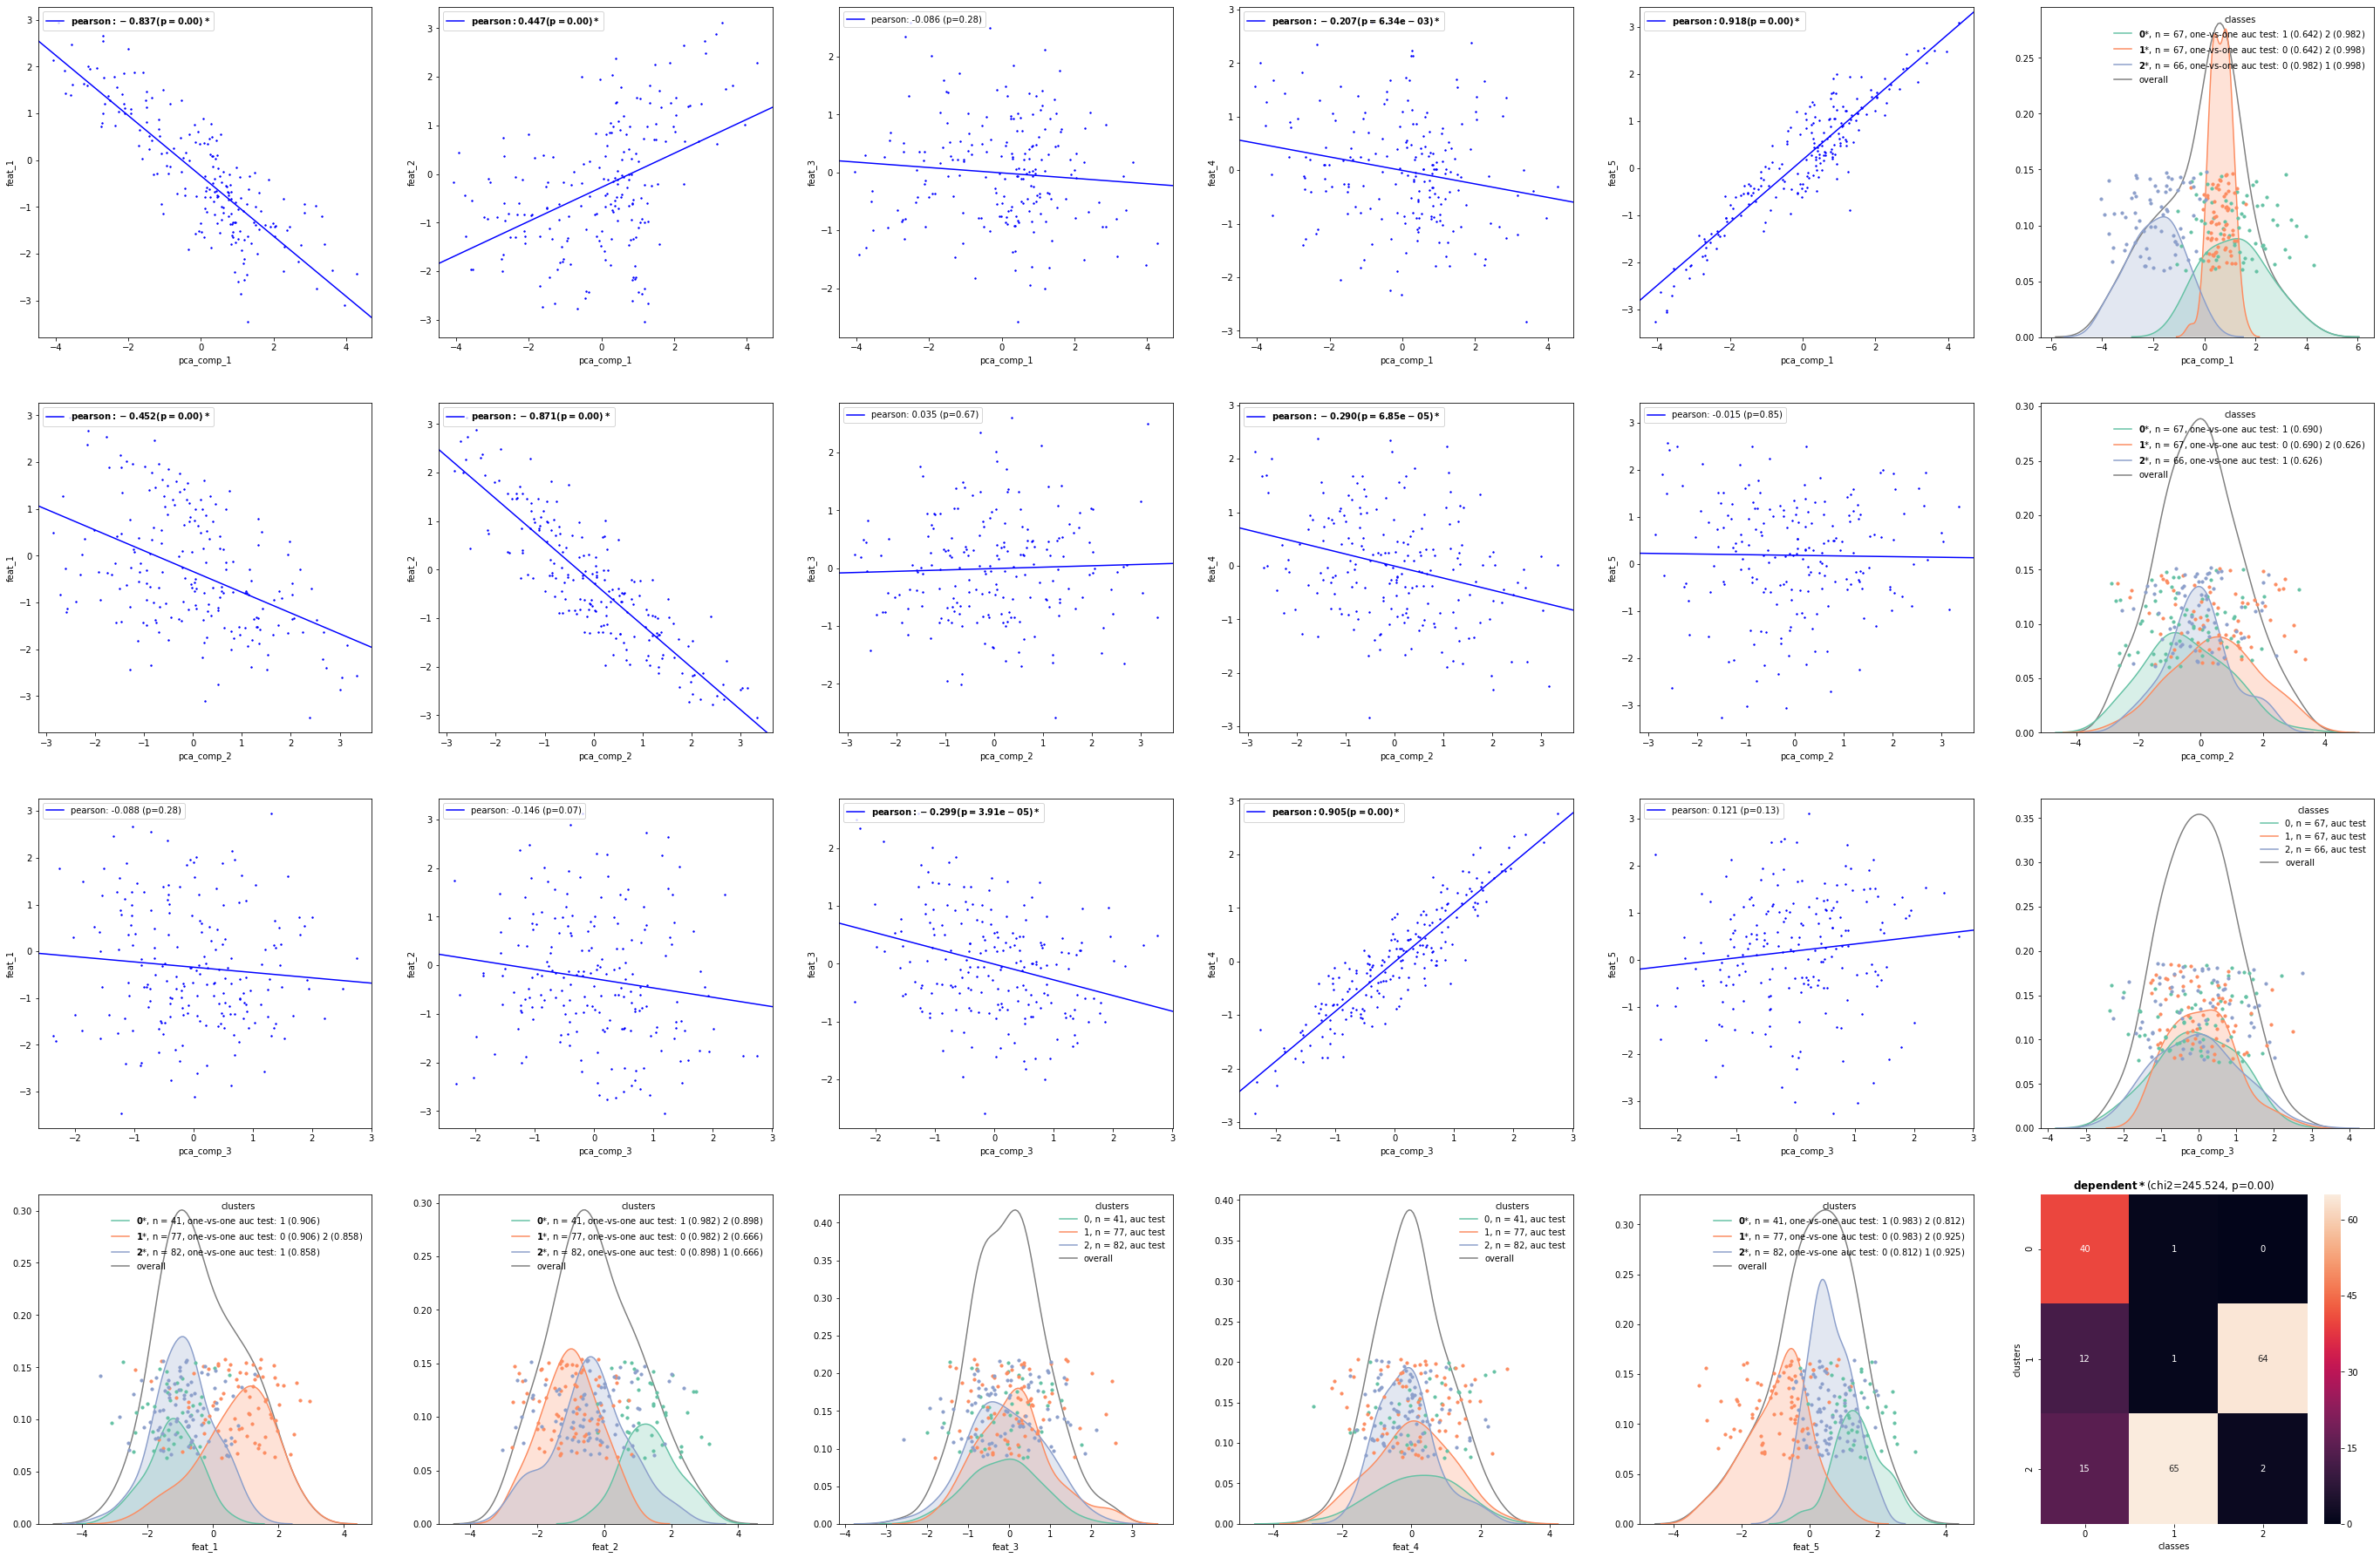

In [8]:
bb = BlockBlock()
bb.fit(pca, df)
bb.correct_multi_tests()
bb.plot()